# Caustics optimization

## Overview

This tutorial contains an advanced inverse rendering example: recovering the surface displacement (heightmap)
of a slab of glass such that light passing through it focuses into a specific desired image.

This reproduces the results showcased in Section 4.3 of [Mitsuba 2: A Retargetable Forward and Inverse Renderer](https://rgl.epfl.ch/publications/NimierDavidVicini2019Mitsuba2).


<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Create a simple mesh from Python</li>
  <li>Use the particle tracer integrator (<code>ptracer</code>)</li>
  <li>Load a scene defined procedurally from Python</li>
  <li>Apply a heightmap to a mesh from Python</li>
  <li>Optimize "latent" variables, i.e. variables which are not directly defined as part of the scene but that affect it</li>
</ul>
    
</div>


The scene will be setup as follows:

1. A directional area light (white or colorful, depending on the target image)
2. Light from the emitter passes through a glass slab. We will optimize the slab's surface (via a heightmap)...
3. ...so that light is focused on a receiving plane in a way that reproduces a desired target image.

In order to efficiently render and optimize this scene, we will use the Particle Tracer integrator ([<code>ptracer</code>][1]), which traces rays from the emitter rather than the sensor.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#particle-tracer-ptracer

<center></center>

## 0. Setup

We start by importing Mitsuba and selecting an appropriate variant supporting automatic differentiation (AD), as it is required to compute gradients with respect to the slab's surface.

In [1]:
import os
from os.path import realpath, join

import drjit as dr
import mitsuba as mi

#mi.set_variant('llvm_ad_rgb')
mi.set_variant('cuda_ad_rgb')

## 1. Choosing a configuration

In this tutorial, we can attempt to reproduce either a grayscale image using a uniform emitter, or a color image using an RGB emitter. Here, we define those two options and select one.

Feel free to define additional configurations, e.g. to target a different reference image of your choice.

In [2]:
SCENE_DIR = realpath('../scenes')

CONFIGS = {
    'wave': {
        'emitter': 'gray',
        'reference': join(SCENE_DIR, 'references/wave-1024.jpg'),
    },
    'sunday': {
        'emitter': 'bayer',
        'reference': join(SCENE_DIR, 'references/sunday-512.jpg'),
    },
}

# Pick one of the available configs
config_name = 'sunday'
# config_name = 'wave'

config = CONFIGS[config_name]
print('[i] Reference image selected:', config['reference'])
mi.Bitmap(config['reference'])

[i] Reference image selected: /home/dicedead/Projects/LCAV/pycsou_perso/src/mitsuba/scenes/references/sunday-512.jpg


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma
    uint8 G; // @1, normalized, gamma
    uint8 B; // @2, normalized, gamma
  ],
  data = [ 768 KiB of image data ]
]

In the following cell we define the hyper parameters controlling the optimization, such as the number of iterations and number of samples per pixels for the differentiable rendering simulation.

In [3]:
if 'PYTEST_CURRENT_TEST' not in os.environ:
    config.update({
        'render_resolution': (128, 128),
        'heightmap_resolution': (512, 512),
        'n_upsampling_steps': 4,
        'spp': 32,
        'max_iterations': 100,
        'learning_rate': 3e-5,
    })
else:
    # IGNORE THIS: When running under pytest, adjust parameters to reduce computation time
    config.update({
        'render_resolution': (64, 64),
        'heightmap_resolution': (128, 128),
        'n_upsampling_steps': 0,
        'spp': 8,
        'max_iterations': 25,
        'learning_rate': 3e-5,
    })
    
    
output_dir = realpath(join('.', 'outputs', config_name))
os.makedirs(output_dir, exist_ok=True)
print('[i] Results will be saved to:', output_dir)

[i] Results will be saved to: /home/dicedead/Projects/LCAV/pycsou_perso/src/mitsuba/caustics/outputs/sunday


## 2. Creating the scene

Depending on the chosen configuration, a different type of emitter will need to be used. For this reason, we define the scene dynamically directly from Python as a dictionary and load it with `load_dict()`.

In [4]:
# Make sure that resources from the scene directory can be found
mi.Thread.thread().file_resolver().append(SCENE_DIR)

### Creating the lens mesh

The goal of the optimization is to recover the heightfield that needs to be applied to a slab of glass so that it focuses light in just the right way to reproduce the desired target image.

The heightmap will be represented as a texture and applied to the slab's vertices. For this technique to be effective, the slab must have enough geometric resolution (vertices) to match the heightmap texture.

![Lens mesh preview](lens-heightmap.png)

Here, we generate the appropriate mesh directly from Python: a simple tesselated plane with the desired resolution and save it to disk.

In [5]:
def create_flat_lens_mesh(resolution):
    # Generate UV coordinates
    U, V = dr.meshgrid(
        dr.linspace(mi.Float, 0, 1, resolution[0]),
        dr.linspace(mi.Float, 0, 1, resolution[1]),
        indexing='ij'
    )
    texcoords = mi.Vector2f(U, V)
    
    # Generate vertex coordinates
    X = 2.0 * (U - 0.5)
    Y = 2.0 * (V - 0.5)
    vertices = mi.Vector3f(X, Y, 0.0)

    # Create two triangles per grid cell
    faces_x, faces_y, faces_z = [], [], []
    for i in range(resolution[0] - 1):
        for j in range(resolution[1] - 1):
            v00 = i * resolution[1] + j
            v01 = v00 + 1
            v10 = (i + 1) * resolution[1] + j
            v11 = v10 + 1
            faces_x.extend([v00, v01])
            faces_y.extend([v10, v10])
            faces_z.extend([v01, v11])

    # Assemble face buffer 
    faces = mi.Vector3u(faces_x, faces_y, faces_z)

    # Instantiate the mesh object
    mesh = mi.Mesh("lens-mesh", resolution[0] * resolution[1], len(faces_x), has_vertex_texcoords=True)
    
    # Set its buffers
    mesh_params = mi.traverse(mesh)
    mesh_params['vertex_positions'] = dr.ravel(vertices)
    mesh_params['vertex_texcoords'] = dr.ravel(texcoords)
    mesh_params['faces'] = dr.ravel(faces)
    mesh_params.update()

    return mesh

In [6]:
lens_res = config.get('lens_res', config['heightmap_resolution'])
lens_fname = join(output_dir, 'lens_{}_{}.ply'.format(*lens_res))

if not os.path.isfile(lens_fname):
    m = create_flat_lens_mesh(lens_res)
    m.write_ply(lens_fname)
    print('[+] Wrote lens mesh ({}x{} tesselation) file to: {}'.format(*lens_res, lens_fname))

### Creating the emitter

As explained previously, depending on whether we are trying to reproduce a grayscale or colorful target image, we setup the emitter to either emit constant white light or an RGB Bayer pattern.
In the latter case, the pattern is generated on-the-fly and passed to the emitter as an in-memory [<code>Bitmap</code>][1] texture.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_textures.html#bitmap-texture-bitmap

In [7]:
emitter = None
if config['emitter'] == 'gray':
    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'spectrum', 
            'value': 0.8
        },
    }
elif config['emitter'] == 'bayer':
    bayer = dr.zeros(mi.TensorXf, (32, 32, 3))
    bayer[ ::2,  ::2, 2] = 2.2
    bayer[ ::2, 1::2, 1] = 2.2
    bayer[1::2, 1::2, 0] = 2.2

    emitter = {
        'type':'directionalarea',
        'radiance': {
            'type': 'bitmap',
            'bitmap': mi.Bitmap(bayer),
            'raw': True,
            'filter_type': 'nearest'
        },
    }

### Creating the integrator

The chosen light source emits light in a single direction, which would be very difficult (or impossible) to sample correctly with a standard path tracer. For this reason, we use a particle tracer (`ptracer`), which starts rays from the emitters rather than the sensor.

In [8]:
integrator = {
    'type': 'ptracer',
    'samples_per_pass': 256,
    'max_depth': 4,
    'hide_emitters': False,
}

### Assembling the scene

The sensor looks directly at the receiving plane where the caustic will be formed. The light source and optimized lens will stand behind the camera.
Note that since the camera is an idealized pinhole camera and does not occupy any space, it will not cast any shadow on the receiving plane.

In [9]:
# Looking at the receiving plane, not looking through the lens
sensor_to_world = mi.ScalarTransform4f.look_at(
    target=[0, -20, 0],
    origin=[0, -4.65, 0],
    up=[0, 0, 1]
)
resx, resy = config['render_resolution']
sensor = {
    'type': 'perspective',
    'near_clip': 1,
    'far_clip': 1000,
    'fov': 45,
    'to_world': sensor_to_world,

    'sampler': {
        'type': 'independent',
        'sample_count': 512  # Not really used
    },
    'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'pixel_format': 'rgb',
        'rfilter': {
            # Important: smooth reconstruction filter with a footprint larger than 1 pixel.
            'type': 'gaussian'
        }
    },
}

We can now put everything together into a single large dictionary, where we also define the remaining geometry (receiving plane, geometry, etc).

In [10]:
scene = {
    'type': 'scene',
    'sensor': sensor,
    'integrator': integrator,
    # Glass BSDF
    'simple-glass': {
        'type': 'dielectric',
        'id': 'simple-glass-bsdf',
        'ext_ior': 'air',
        'int_ior': 1.5,
        'specular_reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    'white-bsdf': {
        'type': 'diffuse',
        'id': 'white-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (1, 1, 1) },
    },
    'black-bsdf': {
        'type': 'diffuse',
        'id': 'black-bsdf',
        'reflectance': { 'type': 'spectrum', 'value': 0 },
    },
    # Receiving plane
    'receiving-plane': {
        'type': 'obj',
        'id': 'receiving-plane',
        'filename': 'meshes/rectangle.obj',
        'to_world': \
            mi.ScalarTransform4f.look_at(
                target=[0, 1, 0],
                origin=[0, -7, 0],
                up=[0, 0, 1]
            ).scale((5, 5, 5)),
        'bsdf': {'type': 'ref', 'id': 'white-bsdf'},
    },
    # Glass slab, excluding the 'exit' face (added separately below)
    'slab': {
        'type': 'obj',
        'id': 'slab',
        'filename': 'meshes/slab.obj',
        'to_world': mi.ScalarTransform4f.rotate(axis=(1, 0, 0), angle=90),
        'bsdf': {'type': 'ref', 'id': 'simple-glass'},
    },
    # Glass rectangle, to be optimized
    'lens': {
        'type': 'ply',
        'id': 'lens',
        'filename': lens_fname,
        'to_world': mi.ScalarTransform4f.rotate(axis=(1, 0, 0), angle=90),
        'bsdf': {'type': 'ref', 'id': 'simple-glass'},
    },

    # Directional area emitter placed behind the glass slab
    'focused-emitter-shape': {
        'type': 'obj',
        'filename': 'meshes/rectangle.obj',
        'to_world': mi.ScalarTransform4f.look_at(
            target=[0, 0, 0],
            origin=[0, 5, 0],
            up=[0, 0, 1]
        ),
        'bsdf': {'type': 'ref', 'id': 'black-bsdf'},
        'focused-emitter': emitter,
    },
}

Finally, the scene is loaded which instantiates all of the appropriate plugins, loads the geometry, etc.

In [11]:
# scene = mi.load_dict(scene) # NO: LATER

## 3. Loading the reference image

Now that the sensor has been defined, we can load the reference image and ensure that its resolution matches the render resolution.

In [12]:
def load_ref_image(config, resolution, output_dir):
    b = mi.Bitmap(config['reference'])
    b = b.convert(mi.Bitmap.PixelFormat.RGB, mi.Bitmap.Float32, False)
    if b.size() != resolution:
        b = b.resample(resolution)

    mi.util.write_bitmap(join(output_dir, 'out_ref.exr'), b)
    
    print('[i] Loaded reference image from:', config['reference'])
    return mi.TensorXf(b)

## 4. Creating the displacement texture

Rather than optimizing the unconstrained vertex positions of the lens directly, we optimize values of a high-resolution heightmap. Here, we create the heightmap texture and create an optimizer that will work on its values.

Notice how the `traverse()` method is used directly on our new texture object, rather than on the scene loaded earlier.

In [13]:
initial_heightmap_resolution = [r // (2 ** config['n_upsampling_steps']) 
                                for r in config['heightmap_resolution']]
upsampling_steps = dr.sqr(dr.linspace(mi.Float, 0, 1, config['n_upsampling_steps']+1, endpoint=False).numpy()[1:])
upsampling_steps = (config['max_iterations'] * upsampling_steps).astype(int)
print('The resolution of the heightfield will be doubled at iterations:', upsampling_steps)

heightmap_texture = mi.load_dict({
    'type': 'bitmap',
    'id': 'heightmap_texture',
    'bitmap': mi.Bitmap(dr.zeros(mi.TensorXf, initial_heightmap_resolution)),
    'raw': True,
})

# Actually optimized: the heightmap texture

The resolution of the heightfield will be doubled at iterations: [ 4 16 36 64]


## 5. Applying the displacement texture

At each iteration, the lens' vertices will displaced from their original position along their normal by the value of the heightmap.
Don't forget that the geometric resolution of the lens mesh (number of vertices) must also be high enough for this technique to work as expected.

In [14]:
# params_scene = mi.traverse(scene)
#
# # We will always apply displacements along the original normals and
# # starting from the original positions.
# positions_initial = dr.unravel(mi.Vector3f, params_scene['lens.vertex_positions'])
# normals_initial   = dr.unravel(mi.Vector3f, params_scene['lens.vertex_normals'])
#
# lens_si = dr.zeros(mi.SurfaceInteraction3f, dr.width(positions_initial))
# lens_si.uv = dr.unravel(type(lens_si.uv), params_scene['lens.vertex_texcoords'])
#
# def apply_displacement(amplitude = 1.):
#     # Enforce reasonable range. For reference, the receiving plane
#     # is 7 scene units away from the lens.
#     vmax = 1 / 100.
#     params['data'] = dr.clamp(params['data'], -vmax, vmax)
#     dr.enable_grad(params['data'])
#
#     height_values = heightmap_texture.eval_1(lens_si)
#     new_positions = (height_values * normals_initial * amplitude + positions_initial)
#     params_scene['lens.vertex_positions'] = dr.ravel(new_positions)
#     params_scene.update()
#
# LATER

## 6. Running the optimization

We're finally ready to start the optimization itself!

At each iteration, we apply the current heightmap displacement to the lens surface and render the scene with automatic differentiation enabled.

We then compare the render to our target image with a scale-independent L2 loss.
We divide out the average brightness in the loss so that the general brightness of the emitter (set arbitrarily) does not interfere with the optimization.

After backpropagating through the computation graph, we use the gradients of the loss w.r.t. the heightmap values to update the heightmap.

In [15]:
def scale_independent_loss(image, ref):
    """Brightness-independent L2 loss function."""
    scaled_image = image / dr.mean(dr.detach(image))
    scaled_ref = ref / dr.mean(ref)
    return dr.mean(dr.sqr(scaled_image - scaled_ref))

We add two common tricks to improve the quality of the optimization:

- Increasing the rendering quality (sample count) and decreasing the learning rate towards the end of the optimization.
- Progressively increasing the resolution of the heightmap being optimized.

In [16]:
params = mi.traverse(heightmap_texture)
params.keep(['data'])
opt = mi.ad.Adam(lr=config['learning_rate'], params=params)

In [17]:
scene = mi.load_dict(scene)

# Make sure the reference image will have a resolution matching the sensor
sensor = scene.sensors()[0]
crop_size = sensor.film().crop_size()
image_ref = load_ref_image(config, crop_size, output_dir=output_dir)

params_scene = mi.traverse(scene)

# We will always apply displacements along the original normals and
# starting from the original positions.
positions_initial = dr.unravel(mi.Vector3f, params_scene['lens.vertex_positions'])
normals_initial   = dr.unravel(mi.Vector3f, params_scene['lens.vertex_normals'])

lens_si = dr.zeros(mi.SurfaceInteraction3f, dr.width(positions_initial))
lens_si.uv = dr.unravel(type(lens_si.uv), params_scene['lens.vertex_texcoords'])

def apply_displacement(amplitude = 1.):
    # Enforce reasonable range. For reference, the receiving plane
    # is 7 scene units away from the lens.
    vmax = 1 / 100.
    params['data'] = dr.clamp(params['data'], -vmax, vmax)
    dr.enable_grad(params['data'])

    height_values = heightmap_texture.eval_1(lens_si)
    new_positions = (height_values * normals_initial * amplitude + positions_initial)
    params_scene['lens.vertex_positions'] = dr.ravel(new_positions)
    params_scene.update()

[i] Loaded reference image from: /home/dicedead/Projects/LCAV/pycsou_perso/src/mitsuba/scenes/references/sunday-512.jpg


In [18]:
scene

Scene[
  children = [
    SmoothDiffuse[
      reflectance = UniformSpectrum[value=[0]]
    ],
    OBJMesh[
      name = "rectangle.obj",
      bbox = BoundingBox3f[
        min = [-1, 5, -1],
        max = [1, 5, 1]
      ],
      vertex_count = 4,
      vertices = [128 B of vertex data],
      face_count = 2,
      faces = [24 B of face data],
      surface_area = [4],
      face_normals = 0
    ],
    ParticleTracerIntegrator[
      max_depth = 4,
      rr_depth = 5
    ],
    PLYMesh[
      name = "lens_512_512.ply",
      bbox = BoundingBox3f[
        min = [-1, -4.37114e-08, -1],
        max = [1, 4.37114e-08, 1]
      ],
      vertex_count = 262144,
      vertices = [8 MiB of vertex data],
      face_count = 522242,
      faces = [5.98 MiB of face data],
      face_normals = 0
    ],
    OBJMesh[
      name = "rectangle.obj",
      bbox = BoundingBox3f[
        min = [-5, -7, -5],
        max = [5, -7, 5]
      ],
      vertex_count = 4,
      vertices = [128 B of vertex data],


In [19]:
import time

start_time = time.time()
mi.set_log_level(mi.LogLevel.Warn)
iterations = config['max_iterations']
loss_values = []
spp = config['spp']

for it in range(iterations):
    t0 = time.time()

    # Carry over the update to our "latent variable" (the heightmap values)
    params.update(opt)
    
    # Apply displacement and update the scene BHV accordingly
    apply_displacement()

    # Perform a differentiable rendering of the scene
    image = mi.render(scene, params, seed=it, spp=2 * spp, spp_grad=spp)

    # Scale-independent L2 function
    loss = scale_independent_loss(image, image_ref)

    # Back-propagate errors to input parameters and take an optimizer step
    dr.backward(loss)
    
    # Take a gradient step
    opt.step()
    
    # Increase resolution of the heightmap
    if it in upsampling_steps:
        opt['data'] = dr.upsample(opt['data'], scale_factor=(2, 2, 1))

    # Log progress
    elapsed_ms = 1000. * (time.time() - t0)
    current_loss = loss[0]
    loss_values.append(current_loss)
    mi.Thread.thread().logger().log_progress(
        it / (iterations-1),
        f'Iteration {it:03d}: loss={current_loss:g} (took {elapsed_ms:.0f}ms)',
        'Caustic Optimization', '')
    
    
    # Increase rendering quality toward the end of the optimization
    if it in (int(0.7 * iterations), int(0.9 * iterations)):
        spp *= 2
        opt.set_learning_rate(0.5 * opt.lr['data'])
        

end_time = time.time()
print(((end_time - start_time) * 1000) / iterations, ' ms per iteration on average')
mi.set_log_level(mi.LogLevel.Info)

134.17327165603638  ms per iteration on average


In [22]:
spp

128

In [23]:
last_loss = scale_independent_loss(image_ref, image)

In [24]:
type(last_loss)

drjit.cuda.ad.Float

Once the optimization has completed, we save the final heightmap and the corresponding lens with displacement applied.

In [20]:
fname = join(output_dir, 'heightmap_final.exr')
mi.util.write_bitmap(fname, params['data'])
print('[+] Saved final heightmap state to:', fname)

fname = join(output_dir, 'lens_displaced.ply')
apply_displacement()
lens_mesh = [m for m in scene.shapes() if m.id() == 'lens'][0]
lens_mesh.write_ply(fname)
print('[+] Saved displaced lens to:', fname)

[+] Saved final heightmap state to: /home/dicedead/Projects/LCAV/pycsou_perso/src/mitsuba/caustics/outputs/sunday/heightmap_final.exr


2023-01-06 21:59:05 INFO main [Mesh] Writing mesh to "/home/dicedead/Projects/LCAV/pycsou_perso/src/mitsuba/caustics/outputs/sunday/lens_displaced.ply" ..

2023-01-06 21:59:05 INFO main [Mesh] "/home/dicedead/Projects/LCAV/pycsou_perso/src/mitsuba/caustics/outputs/sunday/lens_displaced.ply": wrote 522242 faces, 262144 vertices (14 MiB in 39ms)

[+] Saved displaced lens to: /home/dicedead/Projects/LCAV/pycsou_perso/src/mitsuba/caustics/outputs/sunday/lens_displaced.ply


## 7. Visualizing the results

Finally, we plot the evolution of the loss and show the final result next to the reference.

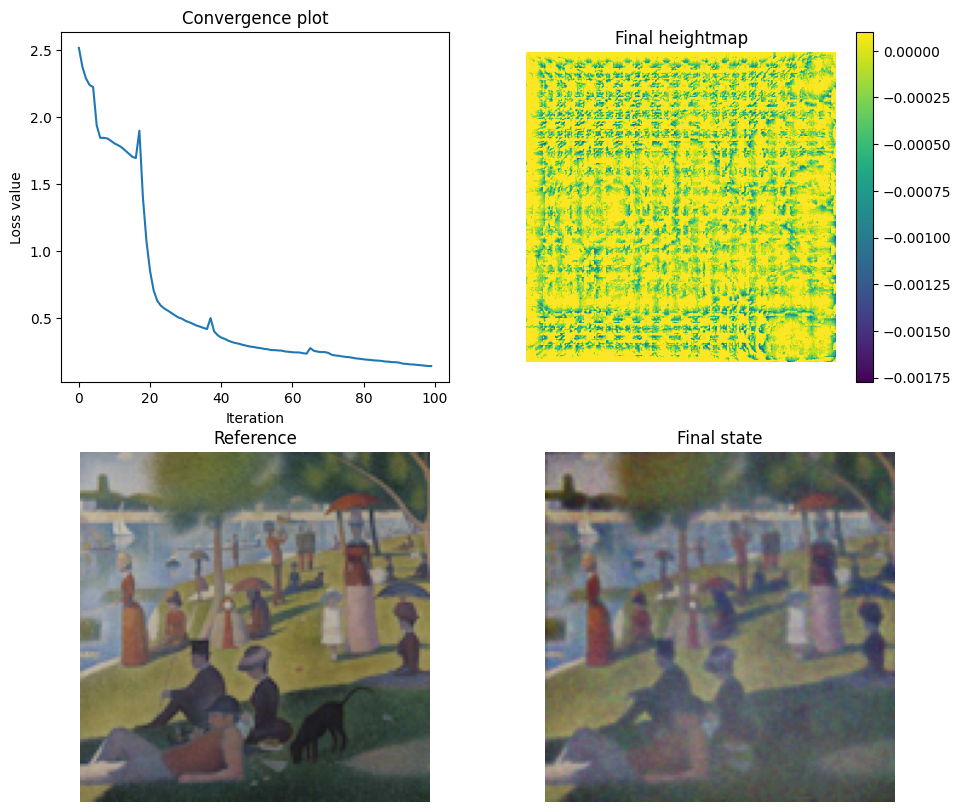

In [21]:
import matplotlib.pyplot as plt

def show_image(ax, img, title):
    ax.imshow(mi.util.convert_to_bitmap(img))
    ax.axis('off')
    ax.set_title(title)
    
def show_heightmap(fig, ax, values, title):
    im = ax.imshow(values.squeeze(), vmax=1e-4)
    fig.colorbar(im, ax=ax)
    ax.axis('off')
    ax.set_title(title)
    
fig, ax = plt.subplots(2, 2, figsize=(11, 10))
ax = ax.ravel()
ax[0].plot(loss_values)
ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Loss value'); ax[0].set_title('Convergence plot')

show_heightmap(fig, ax[1], params['data'].numpy(), 'Final heightmap')
show_image(ax[2], image_ref, 'Reference')
show_image(ax[3], image,     'Final state')
plt.show()

Congratulations! Feel free to define your own target images at the top of the notebook and run this tutorial again.

If you would like to improve the quality of the results, you could try the following:
- Letting the optimization run for more iterations
- Tweaking the learning rate and sample count
- Progressively increasing the resolution of the heightmap through optimization, e.g. starting from a 16x16 heightmap and doubling the resolution every N iterations.

## See also

- [<code>ptracer</code> plugin](https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#particle-tracer-ptracer)
- [<code>bitmap</code> plugin](https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_textures.html#bitmap-texture-bitmap)